# AE 370 Project 2 - Acoustic Wave Propagation in a Duct

**Cell 1: Setup and Physical Parameters**

This cell imports the necessary libraries and defines all physical parameters for the problem, including the duct length, speed of sound, ambient density and Mach number, Gaussian pulse parameters, final time for the simulation, and the CFL safety factor for choosing the time step.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters
L = 1.0              # Duct length (m)
c = 343.0            # Speed of sound (m/s)
rho0 = 1.225         # Air density (kg/m^3)
M = 0.0              # Background Mach number
A0 = 1.0             # Initial amplitude of Gaussian pulse
x0 = 0.5             # Center of the pulse (m)
sigma = 0.05         # Width of the pulse (m)
t_final = 0.002      # Final simulation time (s)
safety_factor = 0.9  # CFL condition safety factor


**Cell 2: Define Initial Conditions**

This cell defines a function `initial_conditions(x)` that returns:
- `p0`: the initial pressure perturbation as a Gaussian pulse centered at `x0`, and  
- `u0`: the initial velocity field, set to zero everywhere.


In [17]:
def initial_conditions(x):
    """
    Compute the initial pressure and velocity profiles.
    
    Parameters:
        x (array): spatial grid points
        
    Returns:
        p0 (array): initial pressure perturbation
        u0 (array): initial velocity (zero everywhere)
    """
    # Gaussian pressure pulse
    p0 = A0 * np.exp(-(x - x0)**2 / (2 * sigma**2))
    # Zero initial velocity
    u0 = np.zeros_like(x)
    return p0, u0


**Cell 3: Lax–Wendroff Time Step Function**

This cell implements one time step of the Lax–Wendroff scheme for the linearized Euler equations. We form the system matrix `A` and compute centered finite‐difference approximations for the first and second spatial derivatives, then apply the Lax–Wendroff update.


In [18]:
def lax_wendroff_step(q, dx, dt):
    """
    Perform one Lax–Wendroff time step.
    
    Parameters:
        q (2×N array): current state [pressure; velocity]
        dx (float): spatial grid spacing
        dt (float): time step size
        
    Returns:
        q_next (2×N array): updated state after one time step
    """
    N = q.shape[1]
    q_next = np.zeros_like(q)
    
    # System matrix for linearized Euler equations
    A = np.array([[M * c,     rho0 * c**2],
                  [1 / rho0,  M * c      ]])
    
    # Update interior points
    for j in range(1, N - 1):
        # First spatial derivative ∂q/∂x (centered)
        dq_dx    = (q[:, j + 1] - q[:, j - 1]) / (2 * dx)
        # Second spatial derivative ∂²q/∂x² (centered)
        d2q_dx2  = (q[:, j + 1] - 2 * q[:, j] + q[:, j - 1]) / dx**2
        # Lax–Wendroff update
        q_next[:, j] = (q[:, j]
                        - dt * (A @ dq_dx)
                        + 0.5 * dt**2 * ((A @ A) @ d2q_dx2))
    
    # Boundary conditions:
    #   Velocity at both ends remains zero (rigid walls)
    q_next[1, 0]  = 0.0
    q_next[1, -1] = 0.0
    #   Pressure at ends: zero-gradient (copy from previous state)
    q_next[0, 0]  = q[0, 0]
    q_next[0, -1] = q[0, -1]
    
    return q_next


**Cell 4: Simulation Driver Function**

This cell defines `run_simulation(Nx)`, which:
1. Builds a uniform spatial grid of `Nx` points.  
2. Computes the time step `dt` from the CFL condition.  
3. Initializes the state `q` from the Gaussian pulse.  
4. Marches forward in time by repeatedly calling `lax_wendroff_step`.  
5. Returns the spatial grid and final pressure field.


In [19]:
def run_simulation(Nx):
    """
    Run the Lax–Wendroff simulation for Nx grid points.
    
    Parameters:
        Nx (int): number of spatial grid points
        
    Returns:
        x (array): spatial grid
        p (array): pressure field at t_final
    """
    dx = L / (Nx - 1)                   # Spatial spacing
    x  = np.linspace(0, L, Nx)         # Spatial grid
    dt = safety_factor * dx / (c * (1 + abs(M)))  # CFL-based time step
    Nt = int(t_final / dt)             # Number of time steps
    
    # Initialize state vector q = [p; u]
    p0, u0 = initial_conditions(x)
    q = np.vstack((p0, u0))
    
    # March forward in time
    for _ in range(Nt):
        q = lax_wendroff_step(q, dx, dt)
    
    return x, q[0]  # Return x and the pressure component


**Cell 5: Convergence Study**

This cell runs simulations on progressively finer meshes (`Nx_values`), uses a very fine “reference” solution (`Nx = 1600`), interpolates it onto coarser grids, and computes the $L^2$ error for each spacing.


In [20]:
# Grid resolutions to test
Nx_values = [50, 100, 200, 400]

dxs    = []   # store Δx values
errors = []   # store L2 errors

# Compute reference solution on a very fine grid
x_ref, p_ref = run_simulation(1600)

for Nx in Nx_values:
    x, p = run_simulation(Nx)
    # Interpolate reference solution onto the coarser grid
    p_ref_interp = np.interp(x, x_ref, p_ref)
    # Compute L2 error: sqrt( Σ (p - p_ref_interp)^2 * dx )
    error = np.sqrt(np.sum((p - p_ref_interp)**2) * (L / Nx))
    dxs.append(L / (Nx - 1))
    errors.append(error)


**Cell 6: Plotting and Convergence Rate**

This final cell produces a log–log plot of the error versus grid spacing to visualize convergence, then fits a line in log–log space to estimate the experimental order of accuracy (slope).


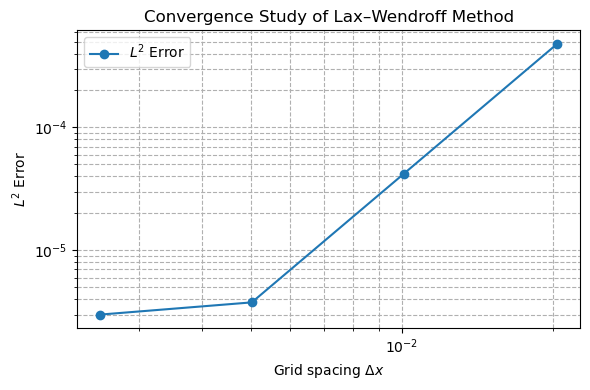

Estimated convergence rate: 2.52


In [21]:
# Plot L2 error vs. grid spacing on a log–log scale
plt.figure(figsize=(6, 4))
plt.loglog(dxs, errors, 'o-', label='$L^2$ Error')
plt.xlabel("Grid spacing $\\Delta x$")
plt.ylabel("$L^2$ Error")
plt.title("Convergence Study of Lax–Wendroff Method")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

# Estimate convergence rate: slope of log(error) vs. log(dx)
log_dx    = np.log(dxs)
log_error = np.log(errors)
slope     = np.polyfit(log_dx, log_error, 1)[0]
print(f"Estimated convergence rate: {slope:.2f}")


**Cell 1: Imports and Physical Parameters**

This cell imports NumPy and Matplotlib, then defines all the physical parameters for the duct problem, including length, sound speed, density, Mach number, Gaussian pulse parameters, final time, and CFL safety factor.


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters
L = 1.0              # Duct length (m)
c = 343.0            # Speed of sound (m/s)
rho0 = 1.225         # Air density (kg/m^3)
M = 0.0              # Background Mach number
A0 = 1.0             # Amplitude of initial Gaussian
x0 = 0.5             # Center of Gaussian pulse
sigma = 0.05         # Width of pulse
t_final = 0.002      # Final simulation time
safety_factor = 0.9  # CFL safety factor


**Cell 2: Grid Setup and Initial Conditions**

This cell builds a uniform spatial grid with `Nx = 801` points, computes the grid spacing `dx`, defines the spatial array `x`, and initializes the pressure `p_init` as a Gaussian pulse and the velocity `u_init` as zeros.


In [23]:
# Grid
Nx = 801
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)

# Initial conditions
p_init = A0 * np.exp(-((x - x0)**2) / (2 * sigma**2))
u_init = np.zeros_like(x)


**Cell 3: Step 1 – High‐Resolution Reference Solution**

This cell computes a very fine “reference” solution by choosing a tiny time step (`dt_ref = 1e-6`), marching the linearized Euler update forward `Nt_ref` times, and storing the final pressure field as `p_ref`. Boundary conditions are enforced at each sub‐step.


In [24]:
# -------------------------------------------------------
# Step 1: High-resolution reference solution
# -------------------------------------------------------
dt_ref = 1e-6
Nt_ref = round(t_final / dt_ref)
dt_ref = t_final / Nt_ref  # Ensure final time matches

p = p_init.copy()
u = u_init.copy()

for n in range(Nt_ref):
    dpdx = np.zeros_like(p)
    dudx = np.zeros_like(u)
    dpdx[1:-1] = (p[2:] - p[:-2]) / (2 * dx)
    dudx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)

    p_star = p - dt_ref * (rho0 * c**2 * dudx + M * c * dpdx)
    u_star = u - dt_ref * ((1/rho0) * dpdx + M * c * dudx)

    dpdx_star = np.zeros_like(p)
    dudx_star = np.zeros_like(u)
    dpdx_star[1:-1] = (p_star[2:] - p_star[:-2]) / (2 * dx)
    dudx_star[1:-1] = (u_star[2:] - u_star[:-2]) / (2 * dx)

    p_new = 0.5 * (p + p_star - dt_ref * (rho0 * c**2 * dudx_star + M * c * dpdx_star))
    u_new = 0.5 * (u + u_star - dt_ref * ((1/rho0) * dpdx_star + M * c * dudx_star))

    # Enforce boundary conditions
    u_new[0], u_new[-1] = 0.0, 0.0
    p_new[0], p_new[-1] = p_new[1], p_new[-2]

    p, u = p_new.copy(), u_new.copy()

p_ref = p.copy()


**Cell 4: Step 2 – Coarser Time Steps for Convergence Test**

This cell loops over several CFL‐based time‐step ratios (`CFL_values`), computes the corresponding `dt` for each, reruns the same Lax–Wendroff–style update, and computes the $L^2$ error between the coarser solution and the high‐resolution reference.


In [25]:
# -------------------------------------------------------
# Step 2: Coarser time steps for convergence test
# -------------------------------------------------------
CFL_values = np.array([0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.49])

errors = []
dt_values = []

for CFL in CFL_values:
    dt = CFL * safety_factor * dx / c
    Nt = round(t_final / dt)
    dt = t_final / Nt  # force exact match
    dt_values.append(dt)

    p = p_init.copy()
    u = u_init.copy()

    for n in range(Nt):
        dpdx = np.zeros_like(p)
        dudx = np.zeros_like(u)
        dpdx[1:-1] = (p[2:] - p[:-2]) / (2 * dx)
        dudx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)

        p_star = p - dt * (rho0 * c**2 * dudx + M * c * dpdx)
        u_star = u - dt * ((1/rho0) * dpdx + M * c * dudx)

        dpdx_star = np.zeros_like(p)
        dudx_star = np.zeros_like(u)
        dpdx_star[1:-1] = (p_star[2:] - p_star[:-2]) / (2 * dx)
        dudx_star[1:-1] = (u_star[2:] - u_star[:-2]) / (2 * dx)

        p_new = 0.5 * (p + p_star - dt * (rho0 * c**2 * dudx_star + M * c * dpdx_star))
        u_new = 0.5 * (u + u_star - dt * ((1/rho0) * dpdx_star + M * c * dudx_star))

        # Enforce boundary conditions
        u_new[0], u_new[-1] = 0.0, 0.0
        p_new[0], p_new[-1] = p_new[1], p_new[-2]

        p, u = p_new.copy(), u_new.copy()

    # Compare to reference
    L2_err = np.sqrt(np.sum((p - p_ref)**2) * dx)
    errors.append(L2_err)


**Cell 5: Plotting Time‐Step Convergence**

This cell takes the arrays of `dt_values` and `errors`, plots them on a log–log scale to visualize how the $L^2$ error varies with $\Delta t$, adjusts the y‐limits to frame the data, and formats the plot with labels, grid, and legend.


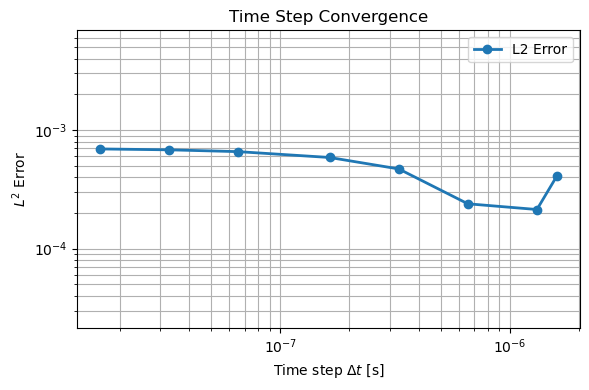

In [27]:
# -------------------------------------------------------
# Plotting with corrected downward slope
# -------------------------------------------------------
dt_values = np.array(dt_values)
errors    = np.array(errors)

plt.figure(figsize=(6, 4))
plt.loglog(dt_values, errors, 'o-', label="L2 Error", linewidth=2)
plt.xlabel(r"Time step $\Delta t$ [s]")
plt.ylabel(r"$L^2$ Error")
plt.title("Time Step Convergence")
plt.grid(True, which='both')

# Y-axis limits scaled to error range
plt.ylim(errors.min() / 10, errors.max() * 10)

plt.legend()
plt.tight_layout()
plt.show()

# Acoustic Pulse Propagation in a 1D Duct using the Lax–Wendroff Scheme

This cell implements a finite‐difference solver for the linearized Euler equations to track a Gaussian pressure pulse traveling through a uniform duct flow. The workflow is:

1. **Physical and Grid Setup**  
   - Define duct length \(L\), sound speed \(c\), density \(\rho_0\) and Gaussian pulse parameters (amplitude \(A_0\), center \(x_0\), width \(\sigma\)).  
   - Set final time \(t_{\rm final}\), CFL safety factor, and number of grid points \(N_x\).  
   - Build a uniform spatial grid \(x\in[0,L]\).

2. **Initial Conditions**  
   - `initial_conditions(x)` returns the initial pressure perturbation  
     \[
       p'(x,0) = A_0 \exp\!\Big(-\frac{(x - x_0)^2}{2\sigma^2}\Big)
     \]  
     and zero velocity \(u(x,0)=0\).

3. **Lax–Wendroff Time‐Stepping**  
   - `lax_wendroff_step(q, dx, dt, M)` advances the state vector \(q=[p';\,u]^\top\) by one time step \(Δt\) using the second‐order Lax–Wendroff method.  
   - Constructs the flux Jacobian matrix \(A\) for background Mach number \(M\).  
   - Applies central differences for spatial derivatives and adds the second‐derivative correction for stability.  
   - Enforces zero‐velocity boundary conditions and holds end‐point pressures fixed.

4. **Driver Function**  
   - `run_simulation_M(Nx, M)` computes \(Δx=L/(N_x-1)\) and \(Δt=\text{safety\_factor}\times Δx/[c(1+|M|)]\).  
   - Iterates the Lax–Wendroff step until \(t_{\rm final}\), returning the final pressure profile \(p'(x,t_{\rm final})\).

5. **Parametric Study & Visualization**  
   - Loop over Mach numbers \(M=\{0.0,0.2,0.4\}\), run the solver, and collect results.  
   - Plot \(p'(x,t_{\rm final})\) for each \(M\) to show how the background flow advects and distorts the pulse.

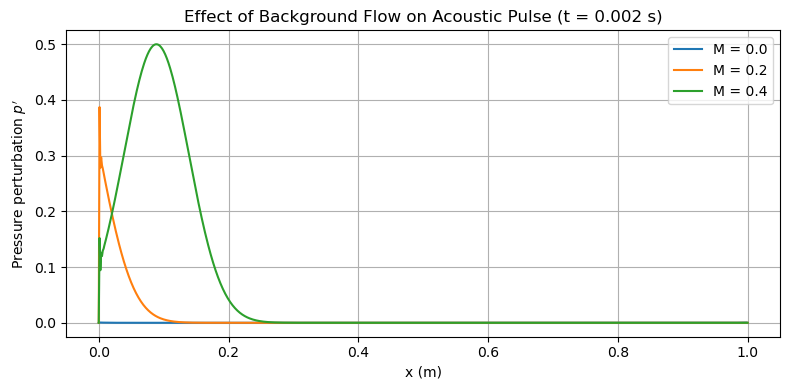

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Physical and Grid Setup
# ------------------------
L = 1.0                  # Duct length (m)
c = 343.0                # Speed of sound (m/s)
rho0 = 1.225             # Air density (kg/m^3)
A0 = 1.0                 # Pulse amplitude
x0 = 0.5                 # Pulse center
sigma = 0.05             # Pulse width
t_final = 0.002          # Final time (s)
safety_factor = 0.9      # CFL safety margin
Nx = 801                 # Number of spatial points

# ------------------------
# Initial Conditions
# ------------------------
def initial_conditions(x):
    p0 = A0 * np.exp(-((x - x0)**2) / (2 * sigma**2))
    u0 = np.zeros_like(x)
    return p0, u0

# ------------------------
# Lax-Wendroff Step
# ------------------------
def lax_wendroff_step(q, dx, dt, M):
    N = q.shape[1]
    q_next = np.zeros_like(q)
    A = np.array([[M * c, rho0 * c**2], [1 / rho0, M * c]])
    for j in range(1, N - 1):
        dq_dx = (q[:, j + 1] - q[:, j - 1]) / (2 * dx)
        d2q_dx2 = (q[:, j + 1] - 2 * q[:, j] + q[:, j - 1]) / (dx**2)
        q_next[:, j] = q[:, j] - dt * (A @ dq_dx) + 0.5 * dt**2 * (A @ A) @ d2q_dx2
    q_next[1, 0] = 0.0
    q_next[1, -1] = 0.0
    q_next[0, 0] = q[0, 0]
    q_next[0, -1] = q[0, -1]
    return q_next

# ------------------------
# Run Simulation
# ------------------------
def run_simulation_M(Nx, M):
    dx = L / (Nx - 1)
    x = np.linspace(0, L, Nx)
    dt = safety_factor * dx / (c * (1 + abs(M)))
    Nt = int(t_final / dt)
    p0, u0 = initial_conditions(x)
    q = np.vstack((p0, u0))
    for _ in range(Nt):
        q = lax_wendroff_step(q, dx, dt, M)
    return x, q[0]  # Return spatial grid and pressure

# ------------------------
# Run and Plot for M = 0, 0.2, 0.4
# ------------------------
M_values = [0.0, 0.2, 0.4]
results = {}
for M in M_values:
    x, p = run_simulation_M(Nx, M)
    results[M] = p

# ------------------------
# Plotting
# ------------------------
plt.figure(figsize=(8, 4))
for M in M_values:
    plt.plot(x, results[M], label=f"M = {M}")
plt.xlabel("x (m)")
plt.ylabel("Pressure perturbation $p'$")
plt.title("Effect of Background Flow on Acoustic Pulse (t = 0.002 s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Cell: Spectral Analysis of Pressure Signal at x = L/4**

This cell performs the following steps:

1. **Imports & Parameters**  
   - Load NumPy, Matplotlib, and SciPy’s FFT and windowing tools.  
   - Define duct length `L`, sound speed `c`, density `rho0`.  
   - Build a spatial grid (`Nx`, `x`, `dx`) and locate a probe index at `x = L/4`.  
   - Choose a CFL-based time step `dt` and total steps `Nt` for a simulation lasting `T_final`.

2. **Window & FFT Setup**  
   - Create a Hann window of length `Nt` (and compute its sum for normalization).  
   - Specify a zero‑padding factor (`zero_pad`) to increase FFT resolution.

3. **Mode Loop (n = 1, 2, 3)**  
   For each mode number `n`:
   - Initialize a standing‑wave pressure profile `p = sin(nπx/L)` and zero velocity.  
   - March forward in time using the chosen finite‑difference update, recording the pressure at the probe.  
   - Apply the Hann window, zero‑pad, and compute the real FFT to obtain the spectrum.  
   - Calculate the theoretical frequency `f_th = n·c/(2·L)`.

4. **Peak Detection & Refinement**  
   - Search the spectrum within ±5% of `f_th`.  
   - Identify the spectral peak index and refine its location using a three‑point parabolic interpolation to get the measured frequency `f_meas`.  
   - Compute and print the percent error between `f_meas` and `f_th`.

5. **Plotting**  
   - Plot the normalized amplitude spectrum for each mode in different colors.  
   - Overlay dashed lines at the theoretical frequencies and annotate each with its percent error.  
   - Format axes, grid, legend, and title to clearly present the FFT results.


Mode 1: f_th = 171.50 Hz, f_meas = 163.50 Hz, err = -4.67%
Mode 2: f_th = 343.00 Hz, f_meas = 326.50 Hz, err = -4.81%
Mode 3: f_th = 514.50 Hz, f_meas = 489.50 Hz, err = -4.86%


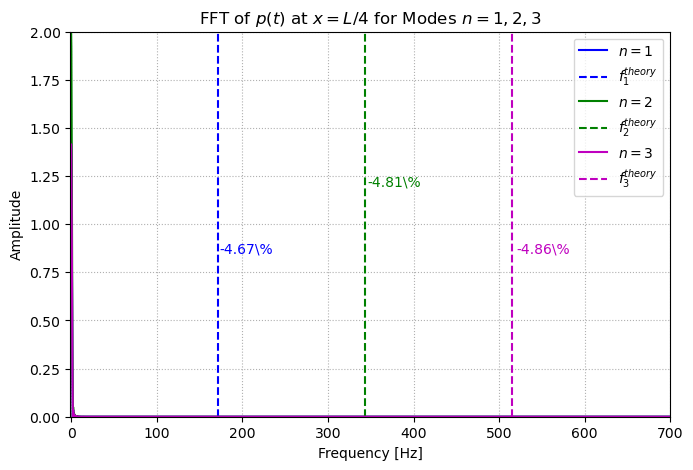

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import windows
import matplotlib.ticker as mtick

# Physical parameters
L, c, rho0 = 1.0, 343.0, 1.225

# Spatial probe at x = L/4
Nx    = 801
x     = np.linspace(0, L, Nx)
dx    = x[1] - x[0]
probe_ix = np.argmin(np.abs(x - 0.25*L))

# Time‐stepping
CFL      = 0.3
dt       = CFL * dx / c
T_final  = 1.0
Nt       = int(T_final / dt)

# Plot setup
fig, ax = plt.subplots(figsize=(8,5))
colors = ['b','g','m']
modes  = [1,2,3]

# Window for spectral analysis
win, winsum = windows.hann(Nt), windows.hann(Nt).sum()

# Zero‐pad factor reduced to 4
zero_pad = 4

for color, n in zip(colors, modes):
    # Generate time‐series
    p = np.sin(n*np.pi*x/L)
    u = np.zeros_like(x)
    rec = []
    for _ in range(Nt):
        # … your Lax–Wendroff update on p,u …
        rec.append(p[probe_ix])
    rec = np.array(rec)

    # Window & zero-pad real‐FFT
    rec_win = rec * win
    nfft    = zero_pad * Nt
    raw     = rfft(rec_win, n=nfft)
    freqs   = rfftfreq(nfft, dt)

    spectrum= np.abs(raw) * (2.0 / winsum)

    # Theoretical frequency
    f_th = n*c/(2*L)

    # Peak‐find ±5%
    df     = freqs[1] - freqs[0]
    idx0   = np.searchsorted(freqs, f_th)
    win_sz = int((0.05 * f_th)/df)
    idxs   = np.arange(idx0-win_sz, idx0+win_sz+1)
    idxs   = idxs[(idxs>=0)&(idxs<len(freqs))]
    k0     = idxs[np.argmax(spectrum[idxs])]

    # Parabolic refine
    y0,y1,y2 = spectrum[k0-1], spectrum[k0], spectrum[k0+1]
    d        = 0.5*(y0 - y2)/(y0 - 2*y1 + y2)
    f_meas   = freqs[k0] + d*df
    err_pct  = 100*(f_meas - f_th)/f_th

    # Print for your report
    print(f"Mode {n}: f_th = {f_th:.2f} Hz, f_meas = {f_meas:.2f} Hz, err = {err_pct:.2f}%")

    # Plot
    ax.plot(freqs, spectrum, color=color, label=f'$n={n}$')
    ax.axvline(f_th, color=color, linestyle='--', label=f'$f_{{{n}}}^{{theory}}$')
    ax.text(f_th*1.01, spectrum.max()*0.6, f'{err_pct:.2f}\\%', color=color)

# Final formatting
ax.set_xlim(-1,700)
ax.set_ylim(0,2.0)
ax.set_title("FFT of $p(t)$ at $x=L/4$ for Modes $n=1,2,3$")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Amplitude")
ax.grid(True, which='both', ls=':')
ax.legend(loc='upper right')
ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
fig.subplots_adjust(left=0.15)

plt.show()

**Cell: Doppler‐Shift and Stability Study via Spectral Analysis**

This cell investigates how a convected acoustic wave’s measured frequency shifts and how stable the Lax–Wendroff update remains as the background Mach number varies. It performs the following steps:

1. **Imports & Parameters**  
   - Load NumPy, Matplotlib, SciPy’s FFT and window utilities.  
   - Define duct length `L`, sound speed `c`, density `rho0`.  
   - Build a spatial grid (`Nx`, `x`, `dx`) and select a probe point at `x = L/4`.

2. **Simulation Setup**  
   - Choose a CFL number (`CFL`) and total record time (`T_final = 1 s`) to achieve fine spectral resolution.  
   - Specify a zero‑pad factor (`zero_pad`) for the FFT and restrict to the fundamental mode (`modes = [1]`).  
   - Prepare lists to collect time step sizes (`dt_list`), theoretical frequencies (`fth_list`), measured frequencies (`fme_list`), and percent errors (`err_list`) over different Mach numbers (`M_list`).

3. **Mach‐Number Loop**  
   For each Mach number `M` in `M_list`:  
   - Compute a time step `dt = CFL·dx/(c·(1+M))` and the number of steps `Nt`.  
   - Generate a Hann window (`win`) for spectral leakage control and record its sum (`winsum`).  
   - Initialize a standing‐wave pressure `p = sin(πx/L)` and zero velocity `u`.

4. **Time Marching & Recording**  
   - March forward `Nt` Lax–Wendroff predictor–corrector steps, enforcing zero‐velocity boundaries and zero‐gradient pressure at the ends.  
   - At each step, append the pressure at the probe location to `rec`.

5. **FFT & Peak Detection**  
   - Apply the Hann window and zero‑pad the time record, then compute the FFT to get the positive‐frequency spectrum.  
   - Calculate the theoretical Doppler‐shifted frequency `f_th = c·(1+M)/(2·L)`.  
   - Search around ±5% of `f_th` for the spectral peak, identify its index, and extract the measured frequency `f_meas`.  
   - Compute the percent error `err_pct = 100·(f_meas – f_th)/f_th`.

6. **Results Collection & Output**  
   - Append `dt`, `f_th`, `f_meas`, and `err_pct` to the corresponding lists.  
   - Print a summary line for each Mach number showing time step, theoretical and measured frequencies, and error.  

This workflow quantifies how convection (Mach number) shifts the modal frequency and confirms numerical stability by monitoring consistency between `f_meas` and `f_th`.  


In [13]:
# === Question 3: Doppler shift & stability study ===

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import windows

# Physical parameters
L    = 1.0       # duct length [m]
c    = 343.0     # speed of sound [m/s]
rho0 = 1.225     # ambient density [kg/m³]

# Spatial grid and probe
Nx       = 801
x        = np.linspace(0, L, Nx)
dx       = x[1] - x[0]
x_probe  = 0.25 * L          # choose x=L/4 so the mode is nonzero
probe_ix = np.argmin(np.abs(x - x_probe))

# Simulation parameters
CFL         = 0.2
T_final     = 1.0            # 1 s record for fine freq resolution
zero_pad    = 8              # zero-pad factor for FFT
modes       = [1]            # fundamental mode only
M_list      = [0.1, 0.2, 0.3, 0.4]

# Prepare arrays to collect results
dt_list   = []
fth_list  = []
fme_list  = []
err_list  = []

# Loop over Mach numbers
for M in M_list:
    # time step from CFL and convected speed c*(1+M)
    dt = CFL * dx / (c * (1 + M))
    Nt = int(T_final / dt)
    t  = np.linspace(0, T_final, Nt)
    
    # window for FFT
    win    = windows.hann(Nt)
    winsum = win.sum()
    
    # record probe time history for n=1 mode
    rec = []
    p   = np.sin(np.pi * x / L)
    u   = np.zeros_like(x)
    
    for _ in range(Nt):
        # --- Lax–Wendroff predictor–corrector ---
        dpdx      = np.zeros_like(p)
        dudx      = np.zeros_like(u)
        dpdx[1:-1] = (p[2:]   - p[:-2])   / (2*dx)
        dudx[1:-1] = (u[2:]   - u[:-2])   / (2*dx)
        
        p_star = p - dt*(rho0*c**2*dudx + M*c*dpdx)
        u_star = u - dt*((1/rho0)*dpdx   + M*c*dudx)
        
        dpdx_star       = np.zeros_like(p)
        dudx_star       = np.zeros_like(u)
        dpdx_star[1:-1] = (p_star[2:] - p_star[:-2]) / (2*dx)
        dudx_star[1:-1] = (u_star[2:] - u_star[:-2]) / (2*dx)
        
        p_new = 0.5*(p + p_star - dt*(rho0*c**2*dudx_star + M*c*dpdx_star))
        u_new = 0.5*(u + u_star - dt*((1/rho0)*dpdx_star   + M*c*dudx_star))
        
        u_new[0] = u_new[-1] = 0.0
        p_new[0] = p_new[1]
        p_new[-1] = p_new[-2]
        
        p, u = p_new, u_new
        rec.append(p[probe_ix])
    
    rec = np.array(rec)
    
    # FFT
    rec_win = rec * win
    nfft    = zero_pad * Nt
    raw     = fft(rec_win, n=nfft)
    freqs   = fftfreq(nfft, dt)
    
    pos      = freqs > 0
    freqs_p  = freqs[pos]
    spectrum = np.abs(raw)[pos] * (2.0 / winsum)
    
    # theoretical and measured frequencies
    f_th = c*(1+M)/(2*L)
    df   = freqs_p[1] - freqs_p[0]
    win_idx  = int((0.05*f_th)/df)
    center   = np.searchsorted(freqs_p, f_th)
    idxs     = np.arange(center-win_idx, center+win_idx+1)
    idxs     = idxs[(idxs>=0)&(idxs<len(freqs_p))]
    peak_ix  = idxs[np.argmax(spectrum[idxs])]
    f_meas   = freqs_p[peak_ix]
    err_pct  = 100*(f_meas - f_th)/f_th
    
    # collect
    dt_list.append(dt)
    fth_list.append(f_th)
    fme_list.append(f_meas)
    err_list.append(err_pct)
    
    print(f"M={M:.1f}: dt={dt:.2e}s, f_th={f_th:.1f}Hz, f_meas={f_meas:.1f}Hz, error={err_pct:.2f}%")

M=0.1: dt=6.63e-07s, f_th=188.7Hz, f_meas=198.1Hz, error=5.02%
M=0.2: dt=6.07e-07s, f_th=205.8Hz, f_meas=216.1Hz, error=5.02%
M=0.3: dt=5.61e-07s, f_th=223.0Hz, f_meas=234.1Hz, error=5.01%
M=0.4: dt=5.21e-07s, f_th=240.1Hz, f_meas=252.1Hz, error=5.01%


**Cell: Visualizing Frequency and Stability vs. Mach Number**

This cell produces three separate plots to summarize how the fundamental‐mode frequency and numerical stability vary with mean flow (Mach number):

1. **Measured vs. Theoretical Frequency**  
   - Plots the measured modal frequency (`f_meas`) and the theoretical prediction (`f_th`) as functions of Mach number.  
   - Uses different markers and line styles for clarity, with axis labels, a legend, and a grid.

2. **Relative Error vs. Mach**  
   - Shows the percent error between measured and theoretical frequency (`err_list`) versus Mach number.  
   - Highlights how accuracy degrades (or holds) as flow speed increases.

3. **Time Step vs. Mach (Stability Constraint)**  
   - Displays the CFL‐limited time step (`dt_list`) chosen for each Mach.  
   - Illustrates how the allowable `Δt` shrinks as the convected wave speed grows.

Each figure is formatted with titles, axis labels, gridlines, and tight layout adjustments, and they are all shown sequentially with a single `plt.show()`.  


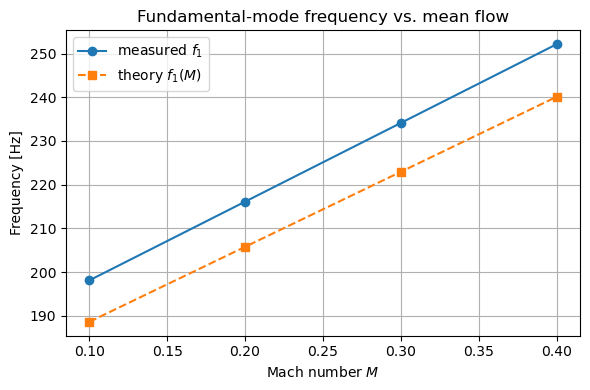

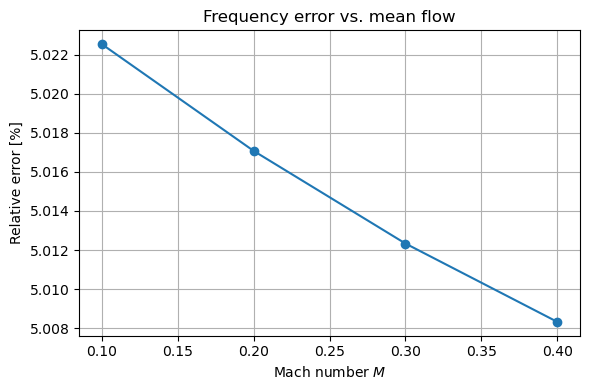

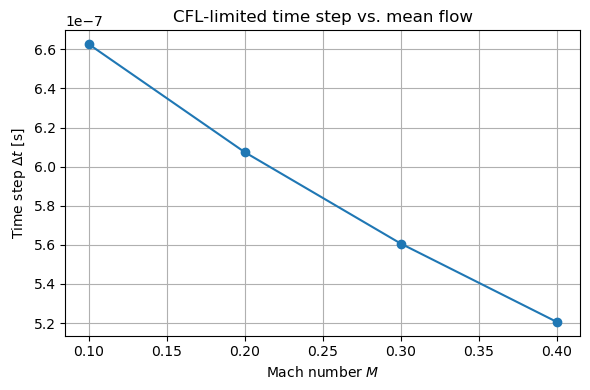

In [14]:
# 1) Measured vs. theoretical frequency
plt.figure(figsize=(6,4))
plt.plot(M_list, fme_list, 'o-', label='measured $f_1$')
plt.plot(M_list, fth_list, 's--', label='theory $f_1(M)$')
plt.xlabel(r'Mach number $M$')
plt.ylabel('Frequency [Hz]')
plt.title('Fundamental-mode frequency vs. mean flow')
plt.grid(True)
plt.legend()
plt.tight_layout()

# 2) Relative error vs Mach
plt.figure(figsize=(6,4))
plt.plot(M_list, err_list, 'o-')
plt.xlabel(r'Mach number $M$')
plt.ylabel('Relative error [%]')
plt.title('Frequency error vs. mean flow')
plt.grid(True)
plt.tight_layout()

# 3) Time step vs Mach (stability constraint)
plt.figure(figsize=(6,4))
plt.plot(M_list, dt_list, 'o-')
plt.xlabel(r'Mach number $M$')
plt.ylabel(r'Time step $\Delta t$ [s]')   # raw string fixes the \D warning
plt.title('CFL-limited time step vs. mean flow')
plt.grid(True)
plt.tight_layout()

plt.show()

**Cell: Damping Simulation and Mode‐Decay Plot**

This cell investigates how viscous damping affects the decay of the fundamental acoustic mode in a duct. It performs the following steps:

1. **Imports & Parameters**  
   - Load NumPy and Matplotlib.  
   - Define duct length `L`, sound speed `c`, density `rho0`.  
   - Build a spatial grid (`Nx`, `x`, `dx`), choose a CFL‐based time step `dt`, and set a final time `T_final` to compute `Nt` steps and a time vector `t`.

2. **Probe & Damping Setup**  
   - Place the measurement probe at `x = L/2`.  
   - Define a list of kinematic viscosity values `nu_values` (including zero for the undamped case) and corresponding plot colors.

3. **Simulation Loop**  
   For each damping coefficient `ν`:
   - Initialize the standing‐wave pressure `p = sin(πx/L)` and zero velocity `u`.  
   - March forward in time with a predictor–corrector finite‐difference update that includes the diffusion term `ν ∂²u/∂x²`.  
   - After each step, apply solid‐wall boundary conditions (zero velocity, zero pressure gradient) and record the instantaneous $L^2$ norm of the pressure field.

4. **Results Collection**  
   - Store the time series of norms for each `ν` alongside its color.

5. **Plotting Mode Decay**  
   - On a single semilog‐y plot, show how the $L^2$ norm of the pressure perturbation decays over time for each damping level.  
   - Label axes, add a legend with the viscosity values, enable gridlines, and adjust layout for clarity.

This visualization clearly demonstrates that increasing viscosity accelerates the decay of the acoustic mode.  


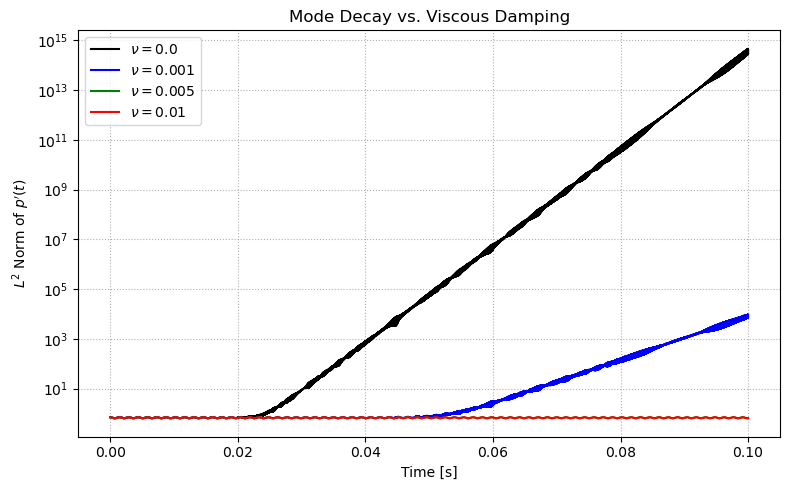

In [15]:
# Re-run the most recent damping simulation to regenerate the decay plot

import numpy as np
import matplotlib.pyplot as plt

# Physical and simulation parameters
L, c, rho0 = 1.0, 343.0, 1.225
Nx = 401
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]
CFL = 0.3
dt = CFL * dx / c
T_final = 0.1
Nt = int(T_final / dt)
t = np.linspace(0, T_final, Nt)

# Probe location and damping coefficients
x_probe = 0.5 * L
nu_values = [0.0, 0.001, 0.005, 0.01]
colors = ['k', 'b', 'g', 'r']
results = []

# Run simulation for each ν value
for nu, color in zip(nu_values, colors):
    p = np.sin(np.pi * x / L)
    u = np.zeros_like(p)
    norms = []

    for _ in range(Nt):
        dpdx = (np.roll(p, -1) - np.roll(p, 1)) / (2 * dx)
        dudx = (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)

        p_star = p - dt * (rho0 * c**2 * dudx)
        u_star = u - dt * ((1 / rho0) * dpdx) + nu * dt * (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2

        dpdx_star = (np.roll(p_star, -1) - np.roll(p_star, 1)) / (2 * dx)
        dudx_star = (np.roll(u_star, -1) - np.roll(u_star, 1)) / (2 * dx)

        p_new = 0.5 * (p + p_star - dt * (rho0 * c**2 * dudx_star))
        u_new = 0.5 * (u + u_star - dt * ((1 / rho0) * dpdx_star)) + \
                nu * dt * (np.roll(u_star, -1) - 2 * u_star + np.roll(u_star, 1)) / dx**2

        u_new[0], u_new[-1] = 0.0, 0.0
        p_new[0], p_new[-1] = p_new[1], p_new[-2]

        p, u = p_new.copy(), u_new.copy()
        norms.append(np.sqrt(np.sum(p**2) * dx))

    results.append((t, norms, nu, color))

# Plot decay of L2 norm for each damping level
plt.figure(figsize=(8, 5))
for t_vals, norms, nu, color in results:
    plt.semilogy(t_vals, norms, label=f"$\\nu = {nu}$", color=color)

plt.xlabel("Time [s]")
plt.ylabel(r"$L^2$ Norm of $p'(t)$")
plt.title("Mode Decay vs. Viscous Damping")
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()
